In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")

In [2]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, explorative = True)
profile.to_file("Task2ProfileReport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Drop some that not make sense

In [3]:
df.drop(columns = ["player_id", "random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

In [4]:
num_cols = df.select_dtypes(include = ["float"]).columns
num_cols.size

31

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Found unique target values: [0, 1, 2, 3]


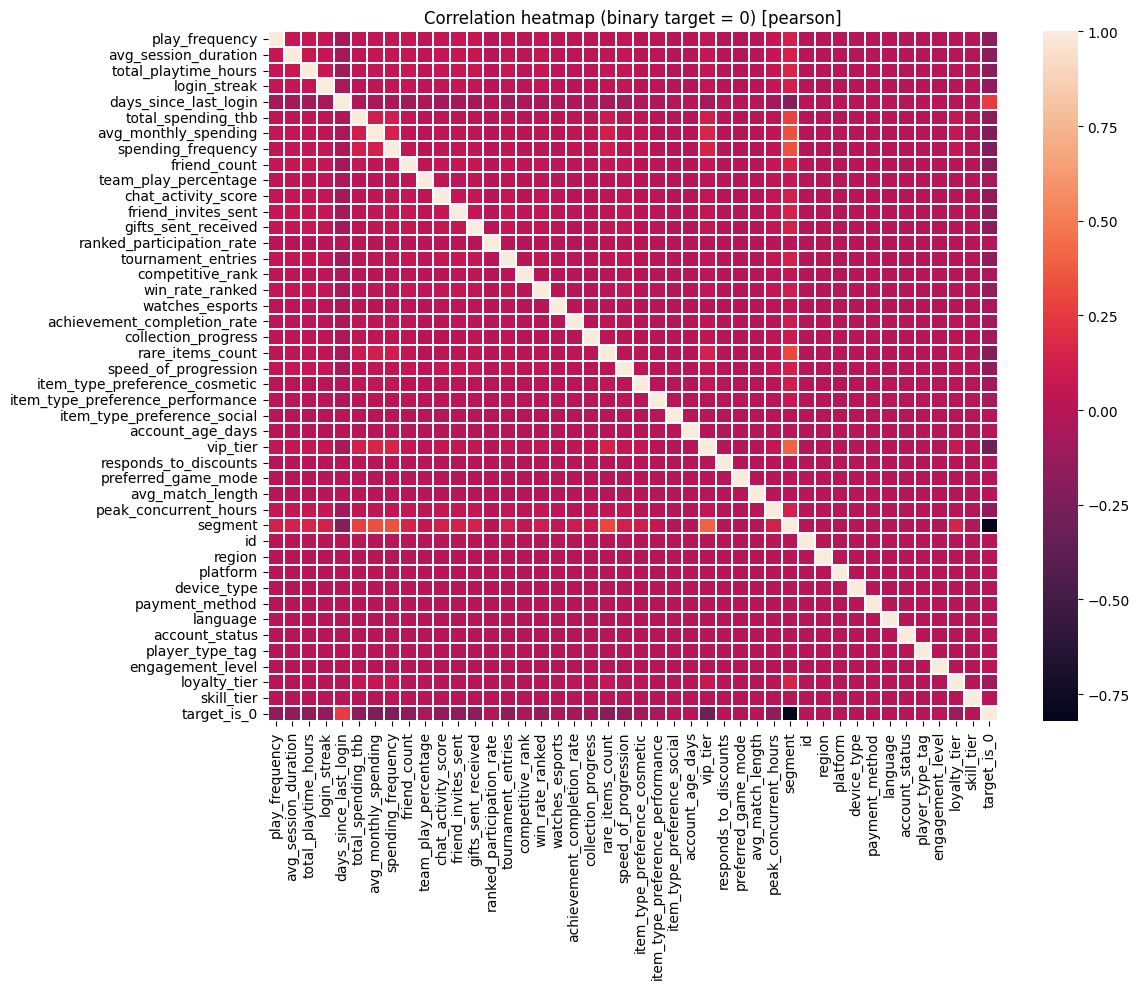


Top features correlated with target == 0:
segment                  0.822063
vip_tier                 0.295859
days_since_last_login    0.252807
avg_monthly_spending     0.235571
spending_frequency       0.235116
rare_items_count         0.207281
total_playtime_hours     0.195110
friend_count             0.183759
total_spending_thb       0.183158
gifts_sent_received      0.175868
avg_session_duration     0.170438
friend_invites_sent      0.169157
peak_concurrent_hours    0.162986
play_frequency           0.161116
speed_of_progression     0.158418
login_streak             0.156270
tournament_entries       0.155638
chat_activity_score      0.153209
win_rate_ranked          0.140331
loyalty_tier             0.104763
Name: target_is_0, dtype: float64


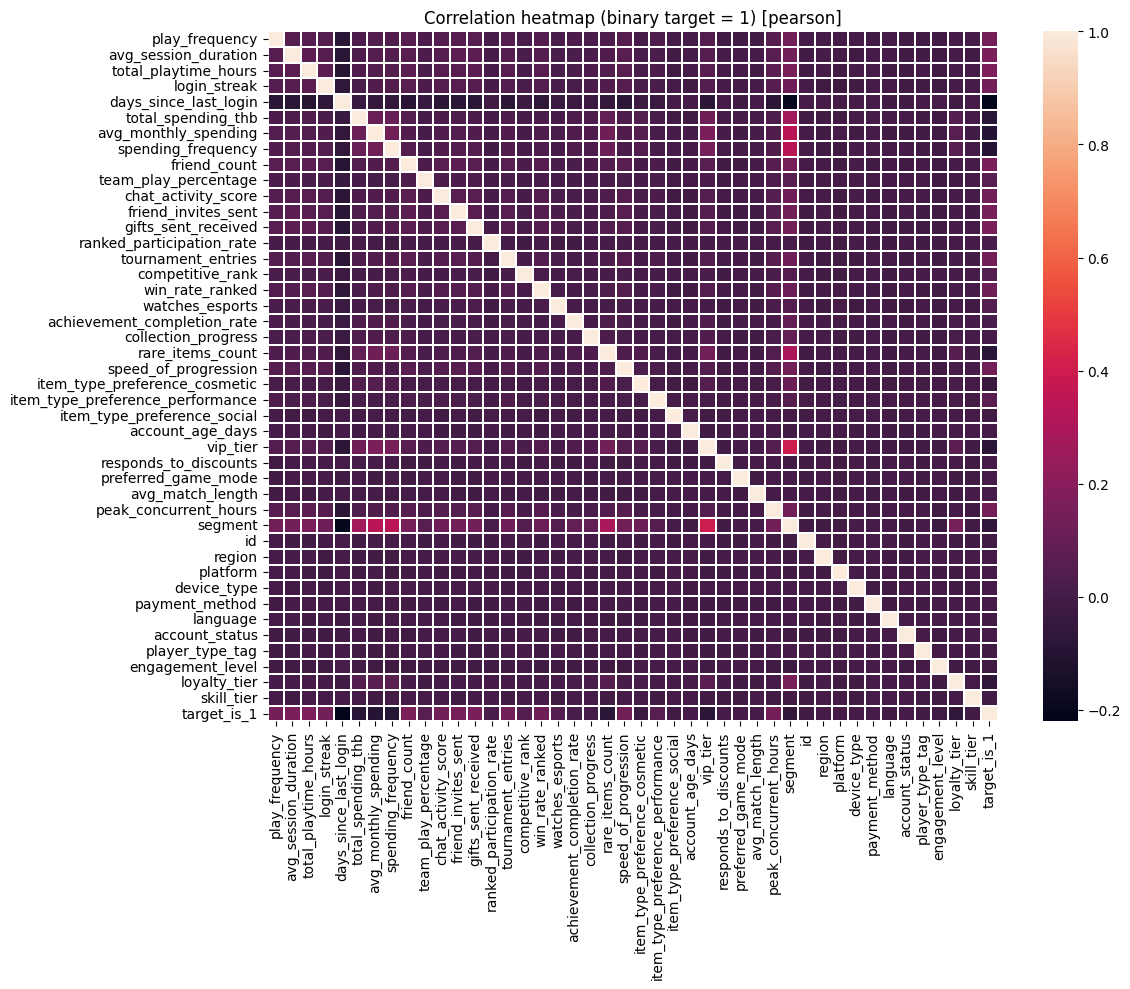


Top features correlated with target == 1:
days_since_last_login    0.220216
total_playtime_hours     0.170486
friend_count             0.161494
gifts_sent_received      0.159868
avg_session_duration     0.157262
friend_invites_sent      0.150678
peak_concurrent_hours    0.146595
play_frequency           0.143447
tournament_entries       0.137595
login_streak             0.137373
speed_of_progression     0.137144
chat_activity_score      0.133424
win_rate_ranked          0.122519
avg_monthly_spending     0.098557
spending_frequency       0.097950
rare_items_count         0.083684
total_spending_thb       0.082941
vip_tier                 0.081240
loyalty_tier             0.064336
team_play_percentage     0.063924
Name: target_is_1, dtype: float64


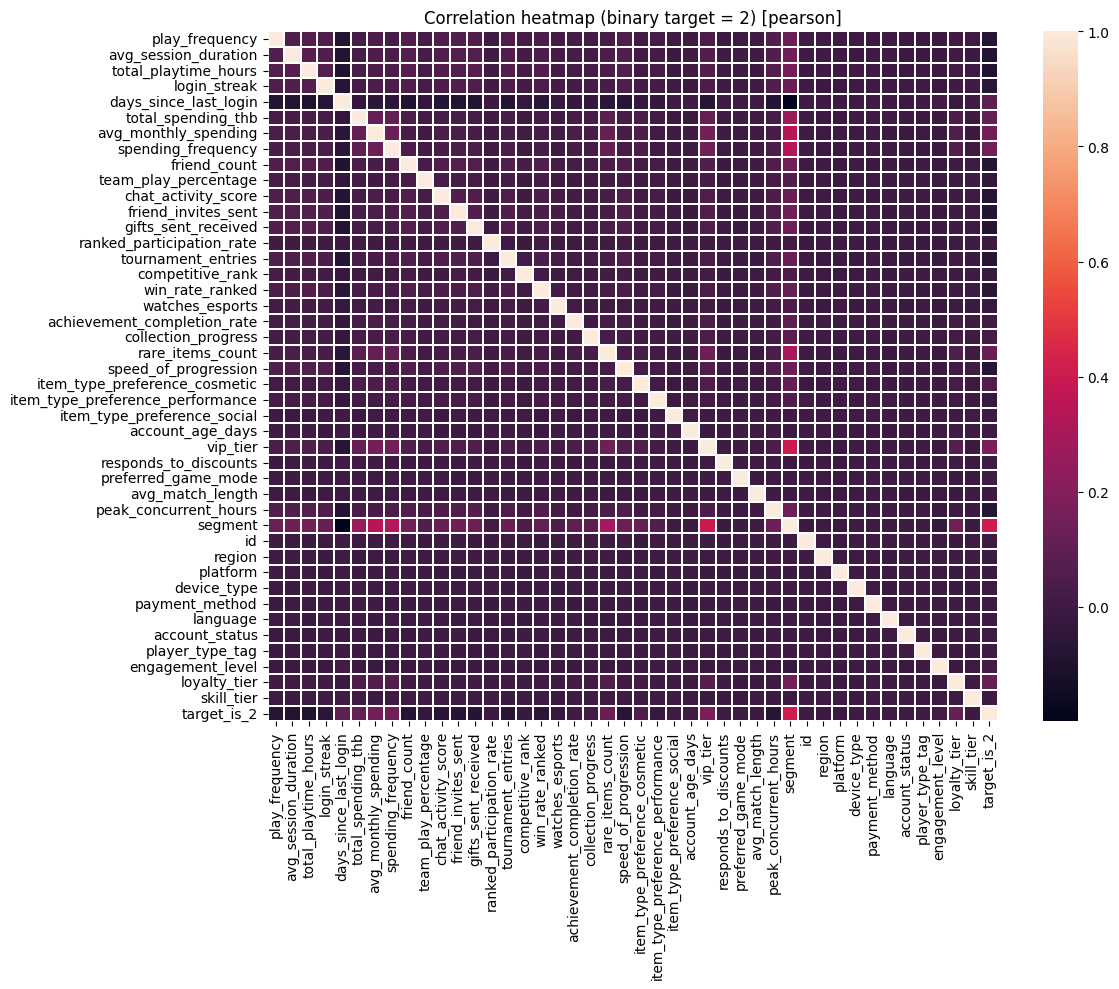


Top features correlated with target == 2:
segment                  0.406485
vip_tier                 0.171112
avg_monthly_spending     0.150980
spending_frequency       0.147304
rare_items_count         0.124485
total_spending_thb       0.114461
loyalty_tier             0.112098
days_since_last_login    0.094902
total_playtime_hours     0.087466
avg_session_duration     0.085273
friend_count             0.081376
friend_invites_sent      0.080702
gifts_sent_received      0.078271
play_frequency           0.073654
peak_concurrent_hours    0.073375
tournament_entries       0.072215
speed_of_progression     0.070835
chat_activity_score      0.070174
login_streak             0.067231
win_rate_ranked          0.061956
Name: target_is_2, dtype: float64


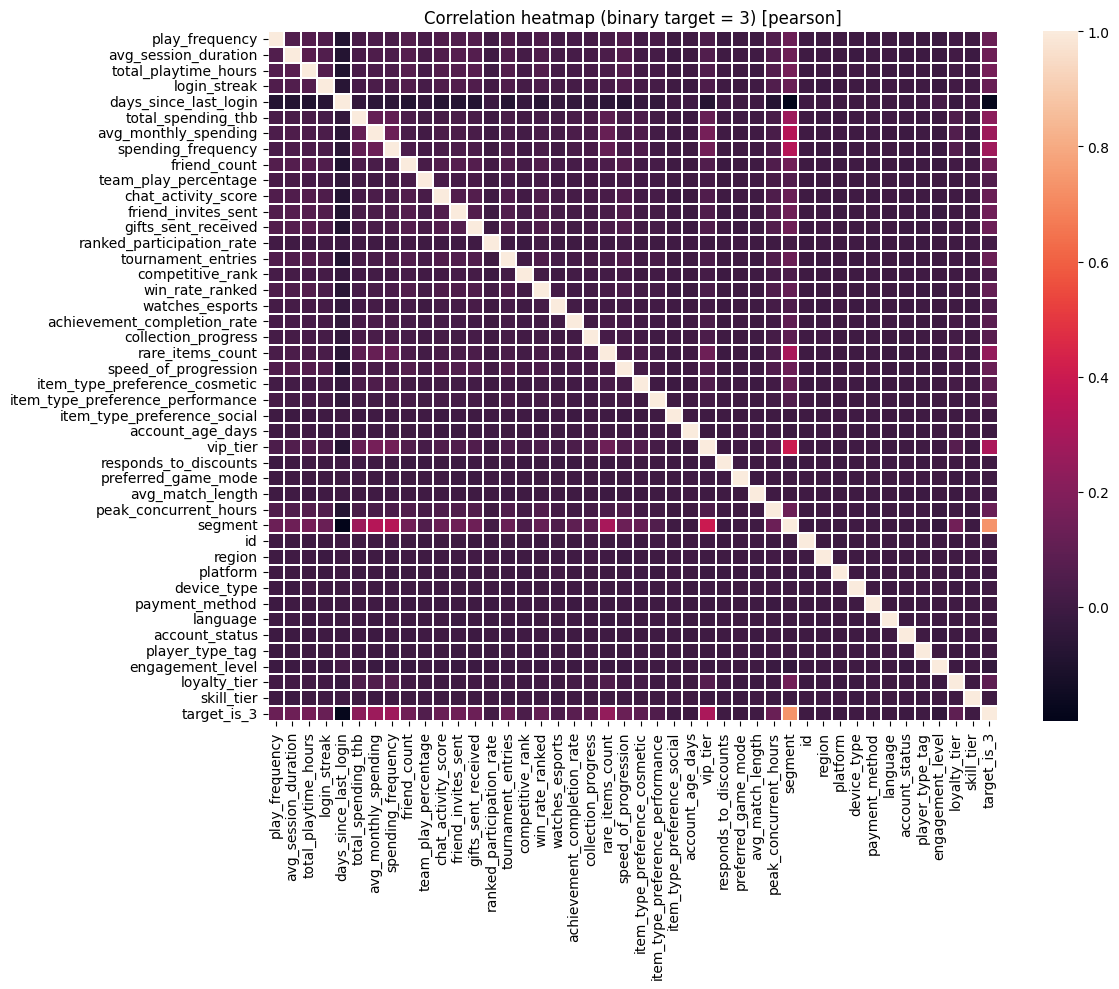


Top features correlated with target == 3:
segment                          0.734071
vip_tier                         0.307498
spending_frequency               0.271987
avg_monthly_spending             0.268899
rare_items_count                 0.242557
total_spending_thb               0.220277
days_since_last_login            0.183479
total_playtime_hours             0.157184
friend_count                     0.145576
friend_invites_sent              0.138237
avg_session_duration             0.136548
gifts_sent_received              0.133485
speed_of_progression             0.128579
play_frequency                   0.128210
peak_concurrent_hours            0.126489
tournament_entries               0.126007
chat_activity_score              0.125478
login_streak                     0.121492
win_rate_ranked                  0.112006
item_type_preference_cosmetic    0.094613
Name: target_is_3, dtype: float64


In [6]:
TARGET_COL = "segment"
CORR_METHOD = "pearson"

numeric_df = df.select_dtypes(include = [np.number]).copy()
numeric_df[TARGET_COL] = df[TARGET_COL]

non_num_cols = [c for c in df.columns if c not in numeric_df.columns and c != TARGET_COL]
for c in non_num_cols:
    try:
        le = LabelEncoder()
        numeric_df[c] = le.fit_transform(df[c].astype(str))
    except Exception:
        # if encoding fails, skip the column
        print(f"Warning: skipping column {c} from encoding")

unique_targets = sorted(df[TARGET_COL].unique())
print("Found unique target values:", unique_targets)

for cls in unique_targets:
    # create a binary target column name
    bin_name = f"target_is_{cls}"
    numeric_df[bin_name] = (df[TARGET_COL] == cls).astype(int)

    # compute correlation matrix over numeric columns
    corr = numeric_df.corr(method = CORR_METHOD)

    # reorder so that binary target is last (nice to view)
    cols = [c for c in corr.columns if c != bin_name] + [bin_name]
    corr = corr.loc[cols, cols]

    # Plot heatmap
    plt.figure(figsize = (12, 10))
    ax = sns.heatmap(
        corr,
        linewidths = 0.3,
    )
    ax.set_title(f"Correlation heatmap (binary target = {cls}) [{CORR_METHOD}]")
    plt.tight_layout()

    plt.show()

    # Also print top features most correlated to the binary target
    corr_with_target = corr[bin_name].drop(bin_name).abs().sort_values(ascending = False)
    print(f"\nTop features correlated with target == {cls}:")
    print(corr_with_target.head(20))

    # remove the binary column to keep df clean for next iteration
    numeric_df.drop(columns = [bin_name], inplace = True)

## Load Data

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")
df.drop(columns = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

ordinal_cols  = {
    "engagement_level": {"Low": 0, "Mid": 1, "High": 2, "Veteran" : 3},
    "loyalty_tier": {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4},
    "skill_tier" : {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4}
}

object_cols = df.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in list(ordinal_cols.keys())]

numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()
numeric_cols.remove("segment")

## Encode Ordinal + Nominal Features

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Encode ordinal features
df_ord = pd.DataFrame()
for col, mapping in ordinal_cols.items():
    df_ord[col] = df[col].map(mapping)

# Encode nominal features
ohe = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

df_nom = pd.DataFrame(
    ohe.fit_transform(df[nominal_cols]),
    columns = ohe.get_feature_names_out(nominal_cols),
    index = df.index
)

In [9]:
from xgboost import XGBClassifier, DMatrix, train as xgb_train

X = pd.concat([df[numeric_cols], df_ord, df_nom], axis = 1)
y = df["segment"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

## Simple XGBoost classifier

In [10]:
model = XGBClassifier(
    objective = "multi:softmax",  # multiclass classification
    num_class = 4,                # classes 0-3
    eval_metric = "mlogloss",
    use_label_encoder = False,
    random_state = 42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

## Evaluation

In [11]:
y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Predictions: [3 2 0 ... 0 1 0]


In [12]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average = "macro")
f1_micro = f1_score(y_test, y_pred, average = "micro")
f1_weighted = f1_score(y_test, y_pred, average = "weighted")

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

F1 Macro: 0.7411
F1 Micro: 0.7562
F1 Weighted: 0.7546


## Feature Importance

In [13]:
importance_scores = model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance_scores
}).sort_values(by = "importance", ascending = False)

feat_importance

,feature,importance
32,loyalty_tier,0.295516
31,engagement_level,0.168525
26,vip_tier,0.064875
4,days_since_last_login,0.026108
6,avg_monthly_spending,0.017695
...,...,...
49,payment_method_Gift,0.003996
43,device_type_Desktop,0.003995
50,payment_method_Wallet,0.003989
47,device_type_nan,0.003976


In [14]:
weak_feature = feat_importance["feature"].tail(30).tolist()

In [15]:
X.drop(columns = weak_feature, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [16]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average = "macro")
f1_micro = f1_score(y_test, y_pred, average = "micro")
f1_weighted = f1_score(y_test, y_pred, average = "weighted")

print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

F1 Macro: 0.7423
F1 Micro: 0.7573
F1 Weighted: 0.7556


In [17]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    # Suggest hyperparameters
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "use_label_encoder": False,
        "objective": "multi:softmax",
        "num_class": 4,
        "eval_metric": "mlogloss"
    }
    
    model = XGBClassifier(**param)
    
    # Stratified k-fold CV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # Evaluate F1 macro
    scores = cross_val_score(model, X, y, cv = cv, scoring = "f1_macro")
    
    return scores.mean()

# Create study
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50)

print("Best trial:")
trial = study.best_trial
print("F1 Macro:", trial.value)
print("Best hyperparameters:", trial.params)

[I 2025-11-27 22:05:35,335] A new study created in memory with name: no-name-402b7ed1-c152-49e7-af9a-9a83efde297f
[I 2025-11-27 22:12:33,317] Trial 0 finished with value: 0.7505367827981475 and parameters: {'max_depth': 10, 'learning_rate': 0.02600524552926147, 'n_estimators': 487, 'subsample': 0.7686217959260411, 'colsample_bytree': 0.7273656208791666, 'gamma': 0.5844998044640315, 'reg_alpha': 0.8881069533043356, 'reg_lambda': 3.5340295676018774}. Best is trial 0 with value: 0.7505367827981475.
[I 2025-11-27 22:12:59,923] Trial 1 finished with value: 0.7482162952550488 and parameters: {'max_depth': 4, 'learning_rate': 0.16393655686798855, 'n_estimators': 195, 'subsample': 0.9129382273417521, 'colsample_bytree': 0.942044884898213, 'gamma': 3.7040948358271613, 'reg_alpha': 4.606998157913739, 'reg_lambda': 1.3292602735200787}. Best is trial 0 with value: 0.7505367827981475.
[I 2025-11-27 22:14:53,454] Trial 2 finished with value: 0.7493371027116235 and parameters: {'max_depth': 7, 'learn

Best trial:
F1 Macro: 0.7526891511409712
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.06691257684527038, 'n_estimators': 366, 'subsample': 0.5058816354238209, 'colsample_bytree': 0.5349875200283156, 'gamma': 3.3916585441686484, 'reg_alpha': 3.0254978910799437, 'reg_lambda': 0.027674390059544862}


## Testset

In [18]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective = "multi:softmax",
    num_class = 4,
    eval_metric = "mlogloss",
    use_label_encoder = False,
    max_depth = 6,
    learning_rate = 0.06691257684527038,
    n_estimators = 366,
    subsample = 0.5058816354238209,
    colsample_bytree = 0.5349875200283156,
    gamma = 3.3916585441686484,
    reg_alpha = 3.0254978910799437,
    reg_lambda = 0.027674390059544862,
    random_state = 42 
)

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5349875200283156, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=3.3916585441686484, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06691257684527038,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=366, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [19]:
inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/test.csv")

inference.drop(
    columns = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"],
    inplace = True
)

In [20]:
ordinal_cols_map = {
    "engagement_level": {"Low": 0, "Mid": 1, "High": 2, "Veteran" : 3},
    "loyalty_tier": {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4},
    "skill_tier" : {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum" : 3, "Diamond" : 4}
}

object_cols = inference.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in ordinal_cols_map.keys()] 

numeric_cols = inference.select_dtypes(include = [np.number]).columns.tolist()

inference_ord = pd.DataFrame()
for col, mapping in ordinal_cols_map.items():
    inference_ord[col] = inference[col].map(mapping)

inference_ord.fillna(-1, inplace = True)
ohe_inference = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

inference_nom = pd.DataFrame(
    ohe.transform(inference[nominal_cols]),
    columns = ohe.get_feature_names_out(nominal_cols),
    index = inference.index
)

In [21]:
X_inference = pd.concat([inference[numeric_cols], inference_ord, inference_nom], axis = 1)
X_inference.drop(columns = weak_feature, inplace = True)

In [22]:
y_pred = model.predict(X_inference)

In [23]:
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")
submit["task2"] = y_pred

In [24]:
submit.to_csv("Test.csv", index = False)

# TreeStackEnsemble

In [25]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")

df.drop(columns = ["id", "player_id"], inplace = True)
df.drop(columns = ["random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

## Build Pipeline

In [26]:
import numpy as np

ordinal_cols  = {
    "engagement_level": ["Low", "Mid", "High", "Veteran"],
    "loyalty_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"],
    "skill_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"]
}

object_cols = df.select_dtypes(include = "object").columns
nominal_cols = [c for c in object_cols if c not in ordinal_cols]

numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()
numeric_cols.remove("segment")

X = df.drop(columns = ["segment"])
y = df["segment"]

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers = [
        ("ord", 
         OrdinalEncoder(
             categories = [ordinal_cols[c] for c in ordinal_cols],
             handle_unknown = "use_encoded_value",
             unknown_value = -1), 
         list(ordinal_cols.keys())
        ),
        ("nom", OneHotEncoder(handle_unknown = "ignore", sparse_output = False), nominal_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [28]:
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        objective = "multi:softmax",
        num_class = len(y.unique()),
        eval_metric = "mlogloss",
        use_label_encoder = False,
        random_state = 42 
    ))
])

xgb_model.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Mid',
                                                                              'High',
                                                                              'Veteran'],
                                                                             ['Bronze',
                                                                              'Silver',
                                                                              'Gold',
                                                                              'Platinum',
                                                                              'Diamond'],
                                                                             ['Bronze',
                                                                              'Silver',
                                                                              'Gold',
                                                                              'Platinum',
                                                                              'Diamond']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['engagement_level',
                                                   'loyalty_tier',
                                                   'skill_tier']),
                                                 ('nom',
                                                  OneHotEncoder(ha...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=4,
                               num_parallel_tree=None, ...))])

## Feature Selection

In [29]:
# Extract Feature Names
X_processed = pd.DataFrame(
    xgb_model.named_steps["preprocess"].transform(X),
    columns = (list(ordinal_cols.keys()) +
               list(xgb_model.named_steps["preprocess"].named_transformers_["nom"].get_feature_names_out(nominal_cols)) + 
               numeric_cols),
    index = X.index
)

# Extract Feature Importance
booster = xgb_model.named_steps["model"].get_booster()
fi = booster.get_score(importance_type = "gain")
fi = pd.Series(fi).sort_values(ascending = False)

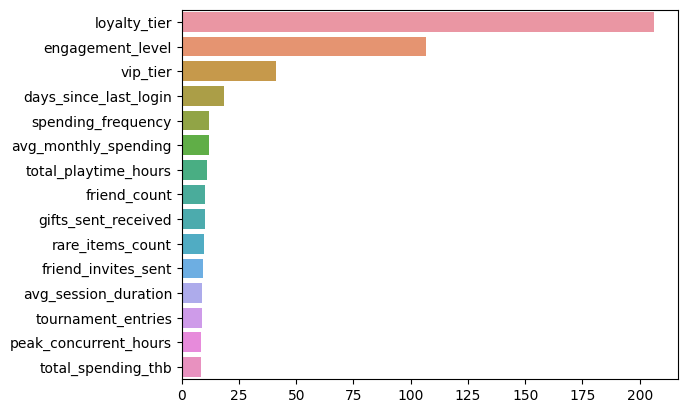

In [30]:
# Visualize

import matplotlib.pyplot as plt
import seaborn as sns

feature_map = {f"f{i}": col for i, col in enumerate(X_processed.columns)}
fi_named = fi.rename(feature_map)

Top15 = fi_named.sort_values(ascending = False).head(15)

sns.barplot(x = Top15.values, y = Top15.index)
plt.show()

In [33]:
cumulative_importance = fi_named.cumsum() / fi_named.sum()
selected_features = cumulative_importance[cumulative_importance <= 0.95].index.tolist()
print(f"Selected {len(selected_features)} features out of {len(fi_named)} total features")

X_selected = X_processed[selected_features].copy()

Selected 53 features out of 67 total features


## Modeling Ensemble

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

estimators = [
    ("XGBoost", XGBClassifier(objective = "multi:softprob",
                             num_class = len(y.unique()),
                             use_label_encoder = False, 
                             eval_metric = "mlogloss", 
                             random_state = 42,
                             n_jobs = 1)),
    
    ("LightGBM", LGBMClassifier(objective = "multiclass", 
                               num_class = len(y.unique()), 
                               metric = "multi_logloss", 
                               random_state = 42,
                               n_jobs = 1)),
    
    ("CatBoost", CatBoostClassifier(loss_function = "MultiClass", 
                                   eval_metric = "MultiClass", 
                                   verbose  = 0, 
                                   random_state = 42,
                                   thread_count = 1))
]

blender = LogisticRegression(
    multi_class = "multinomial",
    max_iter = 2000,
    solver = "saga"   # robust and handles multinomial with L2/L1
)

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",  # use probabilities as meta-features
    cv = 5,                          # internal CV for OOF predictions when building stack
    n_jobs = -1,
    passthrough = False              # don't pass original features to blender
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = cross_val_score(stack, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
print(f"Stacking (XGB+LGBM+Cat -> LR): mean F1 = {scores.mean():.4f}  (+/- {scores.std():.4f})")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training f

## Hyperparameter

CPU is definitely quite painful at this point

In [35]:
import optuna

n_classes = len(y.unique())

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),     
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log = True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),
        "objective": "multi:softprob",
        "num_class": n_classes,
        "use_label_encoder": False,
        "random_state": 42,
        "n_jobs": 1
    }
    
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_xgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 100)
print("Best XGB params:", study_xgb.best_params, "best f1:", 1 - study_xgb.best_value)

[I 2025-11-27 23:59:16,388] A new study created in memory with name: no-name-12b5d6b1-32d7-45d0-afd8-ccdc2d787746
[I 2025-11-28 00:02:30,655] Trial 0 finished with value: 0.2590260973185068 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1618509290001068, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 2.5348407664333426e-07, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.2590260973185068.
[I 2025-11-28 00:06:35,059] Trial 1 finished with value: 0.255114213543723 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.031456163175583855, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.899465584480253, 'gamma': 8.148018307012941e-07, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.255114213543723.
[I 2025-11-28 00:08:00,007] Trial 2 finished with value: 0.25294200377895515 and parameters: {'n_e

Best XGB params: {'n_estimators': 423, 'max_depth': 4, 'learning_rate': 0.10154885306722039, 'subsample': 0.7595823371688654, 'colsample_bytree': 0.4150380825914478, 'gamma': 1.8300918617503547e-07, 'reg_alpha': 2.984212483251443e-08, 'reg_lambda': 1.2323753980848935e-05} best f1: 0.7524036028976036


In [ ]:
def objective_lgb(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 6, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),
        "random_state": 42,
        "objective": "multiclass",
        "n_jobs": 1
    }
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_lgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_lgb.optimize(objective_lgb, n_trials = 100)
print("Best LGB params:", study_lgb.best_params, "best f1:", 1 - study_lgb.best_value)

[I 2025-11-28 04:03:15,886] A new study created in memory with name: no-name-8ed131a2-2708-44e6-ba29-abfe940cdd79
[I 2025-11-28 04:04:20,062] Trial 0 finished with value: 0.25964261563719915 and parameters: {'num_leaves': 52, 'min_child_samples': 96, 'learning_rate': 0.1618509290001068, 'n_estimators': 319, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.49359671220172163, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.25964261563719915.
[I 2025-11-28 04:06:32,303] Trial 1 finished with value: 0.250664066476995 and parameters: {'num_leaves': 79, 'min_child_samples': 72, 'learning_rate': 0.031456163175583855, 'n_estimators': 487, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.5274034664069657, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.250664066476995.
[I 2025-11-28 04:07:11,167] Trial 2 finished with value: 0.25082312243340976 and parameters: {'num_leaves'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931118
[LightGBM] [Info] Start 

[I 2025-11-28 04:16:01,719] Trial 9 finished with value: 0.2506653550246438 and parameters: {'num_leaves': 6, 'min_child_samples': 83, 'learning_rate': 0.15274907837455656, 'n_estimators': 378, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.44442679104045424, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:16:26,483] Trial 10 finished with value: 0.2625811249924055 and parameters: {'num_leaves': 119, 'min_child_samples': 5, 'learning_rate': 0.060927795707490386, 'n_estimators': 58, 'subsample': 0.7828065453407016, 'colsample_bytree': 0.6560877372299885, 'reg_alpha': 4.3444691085504115, 'reg_lambda': 1.2784194237583953e-08}. Best is trial 3 with value: 0.24999831623802604.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start 

[I 2025-11-28 04:17:50,068] Trial 11 finished with value: 0.25306721407498955 and parameters: {'num_leaves': 86, 'min_child_samples': 73, 'learning_rate': 0.05044254225670888, 'n_estimators': 250, 'subsample': 0.8991358530198217, 'colsample_bytree': 0.6152717785058179, 'reg_alpha': 4.077391468444027e-08, 'reg_lambda': 0.005243899131023493}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:18:12,994] Trial 12 finished with value: 0.2557551335883801 and parameters: {'num_leaves': 93, 'min_child_samples': 72, 'learning_rate': 0.06716857388483716, 'n_estimators': 80, 'subsample': 0.8606412847038332, 'colsample_bytree': 0.4046546099992909, 'reg_alpha': 0.0001653282123997987, 'reg_lambda': 1.4359690912042223e-06}. Best is trial 3 with value: 0.24999831623802604.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start 

[I 2025-11-28 04:21:25,861] Trial 13 finished with value: 0.2545335385343346 and parameters: {'num_leaves': 112, 'min_child_samples': 75, 'learning_rate': 0.04235878119394235, 'n_estimators': 499, 'subsample': 0.9912255787291955, 'colsample_bytree': 0.796513435175372, 'reg_alpha': 0.0003064739518184971, 'reg_lambda': 1.0970599363192704e-08}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:22:44,906] Trial 14 finished with value: 0.25519365053172227 and parameters: {'num_leaves': 66, 'min_child_samples': 85, 'learning_rate': 0.0942337878127634, 'n_estimators': 331, 'subsample': 0.7426981218152677, 'colsample_bytree': 0.5571849410138718, 'reg_alpha': 4.648765661147272e-07, 'reg_lambda': 7.831858876558276e-07}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:23:56,167] Trial 15 finished with value: 0.2559756382819015 and parameters: {'num_leaves': 95, 'min_child_samples': 42, 'learning_rate': 0.03147277955885062, 'n_estimators': 159, 'subsample': 0.9262


[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] 

[I 2025-11-28 04:30:03,933] Trial 20 finished with value: 0.251259475743128 and parameters: {'num_leaves': 34, 'min_child_samples': 100, 'learning_rate': 0.049124438589136385, 'n_estimators': 219, 'subsample': 0.8720635229769064, 'colsample_bytree': 0.7360201100965523, 'reg_alpha': 1.193777252895255e-08, 'reg_lambda': 0.00030468089368308873}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:31:37,027] Trial 21 finished with value: 0.25896756732179205 and parameters: {'num_leaves': 128, 'min_child_samples': 82, 'learning_rate': 0.1606450183262372, 'n_estimators': 367, 'subsample': 0.9026058877818017, 'colsample_bytree': 0.4013391226218604, 'reg_alpha': 4.340290398807059e-05, 'reg_lambda': 1.3784974990692315e-07}. Best is trial 3 with value: 0.24999831623802604.



[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 04:32:21,884] Trial 22 finished with value: 0.25401248652274666 and parameters: {'num_leaves': 29, 'min_child_samples': 82, 'learning_rate': 0.12643487790493066, 'n_estimators': 294, 'subsample': 0.8501333829669837, 'colsample_bytree': 0.46995462187702064, 'reg_alpha': 1.534864633801081e-05, 'reg_lambda': 2.3615277240158196e-06}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:33:32,017] Trial 23 finished with value: 0.2596427413361777 and parameters: {'num_leaves': 55, 'min_child_samples': 89, 'learning_rate': 0.16468209301176542, 'n_estimators': 369, 'subsample': 0.7738407030667969, 'colsample_bytree': 0.5026855557321259, 'reg_alpha': 1.6807021528737714e-07, 'reg_lambda': 6.19106883201792e-08}. Best is trial 3 with value: 0.24999831623802604.



[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training 

[I 2025-11-28 04:34:59,790] Trial 24 finished with value: 0.2616901493553404 and parameters: {'num_leaves': 75, 'min_child_samples': 64, 'learning_rate': 0.20899995293076024, 'n_estimators': 445, 'subsample': 0.9100058189523682, 'colsample_bytree': 0.44089987487027255, 'reg_alpha': 2.4337926567438084e-06, 'reg_lambda': 3.5844970600768654e-07}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:35:58,313] Trial 25 finished with value: 0.25110833003540056 and parameters: {'num_leaves': 8, 'min_child_samples': 77, 'learning_rate': 0.12697597510059924, 'n_estimators': 499, 'subsample': 0.8299989305918966, 'colsample_bytree': 0.5793435797962906, 'reg_alpha': 0.0008849299239384577, 'reg_lambda': 7.638675463112413e-06}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:36:54,655] Trial 26 finished with value: 0.2527519502702361 and parameters: {'num_leaves': 26, 'min_child_samples': 90, 'learning_rate': 0.09876156752725362, 'n_estimators': 369, 'subsample': 0.94


[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training 

[I 2025-11-28 04:38:26,083] Trial 27 finished with value: 0.25099652525180915 and parameters: {'num_leaves': 62, 'min_child_samples': 62, 'learning_rate': 0.037286877010175766, 'n_estimators': 291, 'subsample': 0.9997747317714284, 'colsample_bytree': 0.6801606417764081, 'reg_alpha': 5.970826690614986e-05, 'reg_lambda': 9.954464274624007e-05}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:39:09,110] Trial 28 finished with value: 0.2523215544039946 and parameters: {'num_leaves': 6, 'min_child_samples': 78, 'learning_rate': 0.20209481000233234, 'n_estimators': 444, 'subsample': 0.8825609801358081, 'colsample_bytree': 0.44520696904808477, 'reg_alpha': 1.0475430429997831e-05, 'reg_lambda': 3.414323598520157e-07}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:40:12,771] Trial 29 finished with value: 0.252395353619949 and parameters: {'num_leaves': 50, 'min_child_samples': 94, 'learning_rate': 0.08136743990051488, 'n_estimators': 318, 'subsample': 0.679


[LightGBM] [Info] Start training from score -0.931118
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598822
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2025-11-28 04:41:31,616] Trial 30 finished with value: 0.2567649878117484 and parameters: {'num_leaves': 99, 'min_child_samples': 45, 'learning_rate': 0.10440524797377417, 'n_estimators': 243, 'subsample': 0.7182232613237157, 'colsample_bytree': 0.6146244178089864, 'reg_alpha': 1.1544959676962336e-06, 'reg_lambda': 0.020171596309921852}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:42:46,862] Trial 31 finished with value: 0.25033474822595625 and parameters: {'num_leaves': 84, 'min_child_samples': 63, 'learning_rate': 0.052011085237933616, 'n_estimators': 260, 'subsample': 0.8371162565339624, 'colsample_bytree': 0.5328652079160671, 'reg_alpha': 4.8756634477869155e-05, 'reg_lambda': 0.0016195908089929715}. Best is trial 3 with value: 0.24999831623802604.
[I 2025-11-28 04:43:57,820] Trial 32 finished with value: 0.25344419515024286 and parameters: {'num_leaves': 85, 'min_child_samples': 69, 'learning_rate': 0.07488597543948312, 'n_estimators': 280, 'subsample': 0.7


[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 04:46:32,022] Trial 34 finished with value: 0.24963631259848074 and parameters: {'num_leaves': 90, 'min_child_samples': 59, 'learning_rate': 0.03611166276455273, 'n_estimators': 307, 'subsample': 0.860191451300884, 'colsample_bytree': 0.4601461178144034, 'reg_alpha': 4.61059199775413e-06, 'reg_lambda': 0.014724162174447004}. Best is trial 34 with value: 0.24963631259848074.
[I 2025-11-28 04:47:17,774] Trial 35 finished with value: 0.2545730064763315 and parameters: {'num_leaves': 88, 'min_child_samples': 58, 'learning_rate': 0.03799402729744265, 'n_estimators': 148, 'subsample': 0.6031763464480447, 'colsample_bytree': 0.480873297713454, 'reg_alpha': 3.6257759481956516e-06, 'reg_lambda': 0.04287183557027934}. Best is trial 34 with value: 0.24963631259848074.
[I 2025-11-28 04:48:32,408] Trial 36 finished with value: 0.251052693697735 and parameters: {'num_leaves': 106, 'min_child_samples': 34, 'learning_rate': 0.03468575524901913, 'n_estimators': 210, 'subsample': 0.7669839


[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 04:52:16,240] Trial 39 finished with value: 0.2509166499165927 and parameters: {'num_leaves': 46, 'min_child_samples': 54, 'learning_rate': 0.057649341779415796, 'n_estimators': 236, 'subsample': 0.9641616900760804, 'colsample_bytree': 0.5390985039154789, 'reg_alpha': 0.0010398486151454525, 'reg_lambda': 8.117670320293149}. Best is trial 34 with value: 0.24963631259848074.
[I 2025-11-28 04:53:29,541] Trial 40 finished with value: 0.2502476027997287 and parameters: {'num_leaves': 80, 'min_child_samples': 66, 'learning_rate': 0.03625838562636969, 'n_estimators': 274, 'subsample': 0.7971084641916127, 'colsample_bytree': 0.4347583863576763, 'reg_alpha': 0.006343048443042686, 'reg_lambda': 0.000507259369032486}. Best is trial 34 with value: 0.24963631259848074.
[I 2025-11-28 04:54:40,116] Trial 41 finished with value: 0.24918071306857748 and parameters: {'num_leaves': 79, 'min_child_samples': 67, 'learning_rate': 0.03721419976364981, 'n_estimators': 268, 'subsample': 0.8044761


[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGB

[I 2025-11-28 04:55:56,266] Trial 42 finished with value: 0.2502003412145333 and parameters: {'num_leaves': 94, 'min_child_samples': 67, 'learning_rate': 0.03757648939060006, 'n_estimators': 269, 'subsample': 0.8000301847875507, 'colsample_bytree': 0.4253359409573617, 'reg_alpha': 0.0077548426065319545, 'reg_lambda': 0.0005106575904106685}. Best is trial 41 with value: 0.24918071306857748.
[I 2025-11-28 04:57:26,355] Trial 43 finished with value: 0.24956140100565383 and parameters: {'num_leaves': 89, 'min_child_samples': 68, 'learning_rate': 0.03613972976077183, 'n_estimators': 345, 'subsample': 0.760844254807246, 'colsample_bytree': 0.41274891737394165, 'reg_alpha': 0.008628146736932896, 'reg_lambda': 0.00018440604504343282}. Best is trial 41 with value: 0.24918071306857748.
[I 2025-11-28 04:58:55,158] Trial 44 finished with value: 0.25063651466917647 and parameters: {'num_leaves': 92, 'min_child_samples': 71, 'learning_rate': 0.043332800396129904, 'n_estimators': 342, 'subsample': 0.


[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 05:11:03,503] Trial 51 finished with value: 0.24989320005935178 and parameters: {'num_leaves': 111, 'min_child_samples': 72, 'learning_rate': 0.03341334273649278, 'n_estimators': 390, 'subsample': 0.6735848047797824, 'colsample_bytree': 0.41061125970434786, 'reg_alpha': 1.3922431525059915, 'reg_lambda': 1.6568877035571793e-05}. Best is trial 41 with value: 0.24918071306857748.
[I 2025-11-28 05:12:52,452] Trial 52 finished with value: 0.24910228508698506 and parameters: {'num_leaves': 111, 'min_child_samples': 74, 'learning_rate': 0.03361033259637377, 'n_estimators': 389, 'subsample': 0.6985928035219987, 'colsample_bytree': 0.421545248408034, 'reg_alpha': 9.028403038817212, 'reg_lambda': 0.0001250059329830857}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:15:04,644] Trial 53 finished with value: 0.24997183484904117 and parameters: {'num_leaves': 117, 'min_child_samples': 75, 'learning_rate': 0.0342584337852465, 'n_estimators': 419, 'subsample': 0.6225


[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061618 seconds.
You can set `forc

[I 2025-11-28 05:17:02,938] Trial 54 finished with value: 0.25080000379190504 and parameters: {'num_leaves': 114, 'min_child_samples': 58, 'learning_rate': 0.038543965839604954, 'n_estimators': 398, 'subsample': 0.7102817726673424, 'colsample_bytree': 0.4240945066729574, 'reg_alpha': 2.4548982422737713, 'reg_lambda': 2.034068874554484e-05}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:19:15,468] Trial 55 finished with value: 0.2502263345247555 and parameters: {'num_leaves': 122, 'min_child_samples': 61, 'learning_rate': 0.03268501205493717, 'n_estimators': 387, 'subsample': 0.6746653043629225, 'colsample_bytree': 0.4968997243492619, 'reg_alpha': 1.5107613874413208, 'reg_lambda': 0.0001077326404906934}. Best is trial 52 with value: 0.24910228508698506.



[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0

[I 2025-11-28 05:21:20,073] Trial 56 finished with value: 0.25087513989580335 and parameters: {'num_leaves': 127, 'min_child_samples': 84, 'learning_rate': 0.0398792455366812, 'n_estimators': 420, 'subsample': 0.655609647311702, 'colsample_bytree': 0.4161154274975351, 'reg_alpha': 0.6350424314749331, 'reg_lambda': 3.572471135762808e-05}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:22:57,636] Trial 57 finished with value: 0.2493935615557481 and parameters: {'num_leaves': 108, 'min_child_samples': 74, 'learning_rate': 0.03551551269888252, 'n_estimators': 330, 'subsample': 0.7214228120380666, 'colsample_bytree': 0.45534422150442155, 'reg_alpha': 8.225897934460875, 'reg_lambda': 0.0022501356628224552}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:24:32,205] Trial 58 finished with value: 0.2495614166684582 and parameters: {'num_leaves': 99, 'min_child_samples': 69, 'learning_rate': 0.03507675310674126, 'n_estimators': 325, 'subsample': 0.75271279


[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931118
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598822
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2025-11-28 05:27:44,073] Trial 60 finished with value: 0.24914636637089627 and parameters: {'num_leaves': 99, 'min_child_samples': 9, 'learning_rate': 0.04364033508654896, 'n_estimators': 331, 'subsample': 0.7524972223351353, 'colsample_bytree': 0.44693255519848635, 'reg_alpha': 9.975851441227155, 'reg_lambda': 0.19510142196455132}. Best is trial 52 with value: 0.24910228508698506.



[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.386959
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0

[I 2025-11-28 05:29:20,390] Trial 61 finished with value: 0.2495275290667316 and parameters: {'num_leaves': 100, 'min_child_samples': 69, 'learning_rate': 0.030060219508595425, 'n_estimators': 333, 'subsample': 0.7515258902363, 'colsample_bytree': 0.44942119029217786, 'reg_alpha': 7.812031528949704, 'reg_lambda': 0.10643869771664846}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:31:15,600] Trial 62 finished with value: 0.24923758523497364 and parameters: {'num_leaves': 104, 'min_child_samples': 16, 'learning_rate': 0.03093208679364785, 'n_estimators': 356, 'subsample': 0.7291166237840874, 'colsample_bytree': 0.4868957156485972, 'reg_alpha': 7.676183738143962, 'reg_lambda': 0.12067036836729034}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:33:27,208] Trial 63 finished with value: 0.2496394161268387 and parameters: {'num_leaves': 97, 'min_child_samples': 6, 'learning_rate': 0.031108641050292613, 'n_estimators': 365, 'subsample': 0.7303698850420


[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0

[I 2025-11-28 05:42:51,960] Trial 68 finished with value: 0.24929218170412815 and parameters: {'num_leaves': 108, 'min_child_samples': 10, 'learning_rate': 0.04043675112486992, 'n_estimators': 333, 'subsample': 0.8217887416044317, 'colsample_bytree': 0.5274460567826672, 'reg_alpha': 9.897480094855663, 'reg_lambda': 0.4379119775350662}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:45:10,902] Trial 69 finished with value: 0.25228737282574776 and parameters: {'num_leaves': 108, 'min_child_samples': 10, 'learning_rate': 0.05577978933889216, 'n_estimators': 411, 'subsample': 0.8260762565550008, 'colsample_bytree': 0.5228941261729416, 'reg_alpha': 0.19700993578240086, 'reg_lambda': 1.197568321116131}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:47:35,076] Trial 70 finished with value: 0.25140660005113635 and parameters: {'num_leaves': 125, 'min_child_samples': 25, 'learning_rate': 0.040644965528516756, 'n_estimators': 356, 'subsample': 0.783218813


[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6404
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 05:49:16,258] Trial 71 finished with value: 0.24988301020613002 and parameters: {'num_leaves': 102, 'min_child_samples': 18, 'learning_rate': 0.034496592608839007, 'n_estimators': 335, 'subsample': 0.7499498354496753, 'colsample_bytree': 0.4479395874837084, 'reg_alpha': 8.867028274532707, 'reg_lambda': 0.047701422593847735}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:51:04,244] Trial 72 finished with value: 0.24997500935691286 and parameters: {'num_leaves': 114, 'min_child_samples': 11, 'learning_rate': 0.031651044606117985, 'n_estimators': 319, 'subsample': 0.717219494138246, 'colsample_bytree': 0.46742072554050684, 'reg_alpha': 5.319770170521381, 'reg_lambda': 1.270308671198021}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:53:04,028] Trial 73 finished with value: 0.2509225545393323 and parameters: {'num_leaves': 98, 'min_child_samples': 7, 'learning_rate': 0.04338090292853289, 'n_estimators': 378, 'subsample': 0.81284772599


[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931118
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598822
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 05:55:11,946] Trial 74 finished with value: 0.2513607785477445 and parameters: {'num_leaves': 105, 'min_child_samples': 9, 'learning_rate': 0.03914533647818271, 'n_estimators': 323, 'subsample': 0.7301111168079187, 'colsample_bytree': 0.7108057812449273, 'reg_alpha': 9.89677206216606, 'reg_lambda': 0.05132960153506838}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 05:56:55,523] Trial 75 finished with value: 0.2509005650607685 and parameters: {'num_leaves': 111, 'min_child_samples': 15, 'learning_rate': 0.036751142932636205, 'n_estimators': 285, 'subsample': 0.769235601499569, 'colsample_bytree': 0.5065970050786537, 'reg_alpha': 0.9354771998202258, 'reg_lambda': 0.17867783539574808}. Best is trial 52 with value: 0.24910228508698506.



[LightGBM] [Info] Start training from score -1.598822
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 05:58:05,869] Trial 76 finished with value: 0.2502094777356365 and parameters: {'num_leaves': 84, 'min_child_samples': 75, 'learning_rate': 0.04966380986190227, 'n_estimators': 255, 'subsample': 0.6888970918013873, 'colsample_bytree': 0.4415012798651858, 'reg_alpha': 2.566454953357543, 'reg_lambda': 0.001874787244178717}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 06:00:51,453] Trial 77 finished with value: 0.2515964620974497 and parameters: {'num_leaves': 118, 'min_child_samples': 55, 'learning_rate': 0.03000867844145434, 'n_estimators': 360, 'subsample': 0.7862638985639776, 'colsample_bytree': 0.7927975850568149, 'reg_alpha': 4.167521897754055, 'reg_lambda': 3.863096496973695}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 06:03:44,076] Trial 78 finished with value: 0.25517522300800644 and parameters: {'num_leaves': 92, 'min_child_samples': 48, 'learning_rate': 0.06072228397154712, 'n_estimators': 434, 'subsample': 0.75826989537235


[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81326, number of used features: 53
[LightGBM] [Info] Start training from score -0.931137
[LightGBM] [Info] Start training from score -1.387008
[LightGBM] [Info] Start training from score -1.598809
[LightGBM] [Info] Start training from score -1.871218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 8132

[I 2025-11-28 06:10:28,881] Trial 82 finished with value: 0.24938655737512883 and parameters: {'num_leaves': 86, 'min_child_samples': 64, 'learning_rate': 0.037454167947806455, 'n_estimators': 345, 'subsample': 0.5140598136201723, 'colsample_bytree': 0.41089896470187276, 'reg_alpha': 3.465236244795564, 'reg_lambda': 0.0001681875564637275}. Best is trial 52 with value: 0.24910228508698506.
[I 2025-11-28 06:11:56,377] Trial 83 finished with value: 0.249282248841441 and parameters: {'num_leaves': 86, 'min_child_samples': 63, 'learning_rate': 0.04161526222691723, 'n_estimators': 313, 'subsample': 0.5417834278530723, 'colsample_bytree': 0.4348921805484182, 'reg_alpha': 3.453506614742923, 'reg_lambda': 0.0025265155998089716}. Best is trial 52 with value: 0.24910228508698506.



[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931150
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598761
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 81327, number of used features: 53
[LightGBM] [Info] Start training from score -0.931118
[LightGBM] [Info] Start training from score -1.386971
[LightGBM] [Info] Start training from score -1.598822
[LightGBM] [Info] Start training from score -1.871310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067035 seconds.
You can set `forc

In [ ]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log = True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0
    }
    
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_cat = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_cat.optimize(objective_cat, n_trials = 100)
print("Best Cat params:", study_cat.best_params, "best f1:", 1 - study_cat.best_value)

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict

estimators = [
    ("xgb", XGBClassifier(**study_xgb.best_params, verbosity = 0)),
    ("lgbm", LGBMClassifier(**study_lgb.best_params, num_class = n_classes, verbose = -1)),
    ("cat", CatBoostClassifier(**study_cat.best_params))
]

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

def make_meta_dataset(estimators, X, y, cv):
    meta_cols = []
    fitted = []
    for name, est in estimators:
        probs = cross_val_predict(est, X, y, cv = cv, method = "predict_proba", n_jobs = -1)
        meta_cols.append(probs)
        est_full = clone(est)
        est_full.fit(X, y)
        fitted.append((name, est_full))

    # horizontally stack the prob columns from each estimator -> (n_samples, n_estimators * n_classes)
    X_meta = np.hstack(meta_cols)
    return X_meta, fitted

X_meta, fitted_estimators = make_meta_dataset(estimators, X_selected, y, cv)

In [ ]:
def objective_blender_meta(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log = True)
    penalty = trial.suggest_categorical("penalty", ["l2"])  # stick to l2 if desired

    clf = LogisticRegression(
        C = C,
        penalty = penalty,
        multi_class = "multinomial",
        max_iter = 2000,
        solver = "saga" if penalty == "l1" else "lbfgs"
    )

    scores = cross_val_score(clf, X_meta, y, cv = cv, scoring = "f1_macro", n_jobs = -1)
    return 1.0 - scores.mean()

study_blender = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_blender.optimize(objective_blender_meta, n_trials = 100)  # n_trials are cheaply now
print("Best blender params:", study_blender.best_params, "best f1:", 1 - study_blender.best_value)

## Inference

In [18]:
inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/test.csv")

drop_cols = ["id", "player_id", "random_metric_1", "random_metric_2", "random_metric_3"]
inference.drop(columns = [c for c in drop_cols if c in inference.columns], inplace = True)
Q
# Apply existing preprocessor
X_test_processed = pd.DataFrame(
    xgb_model.named_steps["preprocess"].transform(inference),
    columns = (list(ordinal_cols.keys()) + 
               list(xgb_model.named_steps["preprocess"].named_transformers_["nom"].get_feature_names_out(nominal_cols)) + 
               numeric_cols),
    index = inference.index
)

X_test_selected = X_test_processed[selected_features].copy()

In [28]:
# --- Base learners ---
xgb_clf = XGBClassifier(
    **best_xgb_params,
    num_class = n_classes,
    use_label_encoder = False,
    verbosity = 0
)

lgbm_clf = LGBMClassifier(
    **best_lgb_params,
    num_class = n_classes,
    verbose = -1
)

cat_clf = CatBoostClassifier(
    **best_cat_params,
)

# --- Blender (LogisticRegression) ---
blender = LogisticRegression(
    multi_class = "multinomial",
    max_iter = 2000,
    solver = "saga",
    **best_blender_params
)

# --- Stacking ---
estimators = [("xgb", xgb_clf), ("lgbm", lgbm_clf), ("cat", cat_clf)]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

stack.fit(X_selected, y)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.4883568158000777,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.0012094101880661978,
                                              grow_policy=None,
                                              importance_type=None,
                                              in...
                                               objective='multiclass',
                                               random_state=42,
                                               reg_alpha=1.3140531432759214e-08,
                                               reg_lambda=0.013639901223891924,
                                               subsample=0.9099202406509211,
                                               verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7c7fa81e6b50>)],
                   final_estimator=LogisticRegression(C=2.6374250101958565,
                                                      max_iter=2000,
                                                      multi_class='multinomial',
                                                      solver='saga'),
                   n_jobs=-1, stack_method='predict_proba')

In [29]:
y_test_pred = stack.predict(X_test_selected)
y_test_proba = stack.predict_proba(X_test_selected)

In [31]:
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")

submit["task2"] = y_test_pred
submit.to_csv("ThreeTreeStackEnsembleHyperparameter.csv", index = False)

# Imputation Comparison

In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task2/train.csv")

df.drop(columns = ["id", "player_id"], inplace = True)
df.drop(columns = ["random_metric_1", "random_metric_2", "random_metric_3"], inplace = True)

X = df.drop(columns = ["segment"])
y = df["segment"]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

ordinal_cols_given = {
    "engagement_level": ["Low", "Mid", "High", "Veteran"],
    "loyalty_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"],
    "skill_tier": ["Bronze", "Silver", "Gold", "Platinum", "Diamond"]
}

all_object_cols = X.select_dtypes(include = "object").columns.tolist()
ordinal_cols = [c for c in ordinal_cols_given if c in X.columns]
nominal_cols = [c for c in all_object_cols if c not in ordinal_cols]
numeric_cols = X.select_dtypes(include = [np.number]).columns.tolist()

print("ordinal_cols:", ordinal_cols)
print("nominal_cols:", nominal_cols)
print("numeric_cols:", numeric_cols)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor

ordinal_encoder = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OrdinalEncoder(categories = [ordinal_cols_given[c] for c in ordinal_cols]))
]) if ordinal_cols else "drop"

nominal_encoder = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse = False))
]) if nominal_cols else "drop"

numeric_simple = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])

numeric_iter = Pipeline([
    ("iter_imputer", IterativeImputer(
        estimator = LGBMRegressor(
            n_estimators = 50,
            learning_rate = 0.05,
            max_depth = -1,
            subsample = 0.7,
            colsample_bytree = 0.7,
            random_state = 42,
            n_jobs = -1
        ),
        max_iter = 10,
        initial_strategy = "median",
        random_state = 42
    )),
    ("scaler", StandardScaler())
])

pre_simple = ColumnTransformer(
    transformers = [
        ("num", numeric_simple, numeric_cols),
        ("ord", ordinal_encoder, ordinal_cols),
        ("nom", nominal_encoder, nominal_cols)
    ],
    remainder = "drop",
    sparse_threshold = 0
)

pre_iter = ColumnTransformer(
    transformers = [
        ("num", numeric_iter, numeric_cols),
        ("ord", ordinal_encoder, ordinal_cols),
        ("nom", nominal_encoder, nominal_cols)
    ],
    remainder = "drop",
    sparse_threshold = 0
)

## LightGBM Impute, Catboost Comparison

In [ ]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations = 200,
    learning_rate = 0.12,
    depth = 6,
    eval_metric = "MultiClass",
    custom_metric = ["F1"],
    random_seed = 42,
    thread_count = -1,
    verbose = 0
)

pipeline_simple = Pipeline([
    ("pre", pre_simple),
    ("clf", cat_model)
])

pipeline_iter = Pipeline([
    ("pre", pre_iter),
    ("clf", cat_model)
])

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score

def cv_with_earlystop(preprocessor, X, y, n_splits = 5):
    cat_params = dict(
        iterations = 1000,
        learning_rate = 0.08,
        depth = 6,
        eval_metric = "MultiClass",
        custom_metric = ["F1"],
        random_seed = 42,
        thread_count = -1,
        verbose = 0
    )

    kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start = 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_tr_tr = preprocessor.fit_transform(X_tr)
        X_val_tr = preprocessor.transform(X_val)

        model = CatBoostClassifier(**cat_params)
        model.fit(
            X_tr_tr, y_tr,
            eval_set = (X_val_tr, y_val),
            use_best_model = True,
            early_stopping_rounds = 50
        )

        preds = model.predict(X_val_tr)
        f1 = f1_score(y_val, preds, average = "macro")
        print(f"fold {fold} f1_macro = {f1:.4f}")
        scores.append(f1)

    return scores, np.mean(scores), np.std(scores)

In [ ]:
ordinal_encoder = Pipeline([
    ("encoder", OrdinalEncoder(categories = [ordinal_cols_given[c] for c in ordinal_cols],
        handle_unknown = "use_encoded_value", unknown_value = -1))
]) if ordinal_cols else "drop"

nominal_encoder = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse = False, drop = None))
]) if nominal_cols else "drop"

pre_no_impute = ColumnTransformer(
    transformers = [
        ("num", "passthrough", numeric_cols),
        ("ord", ordinal_encoder, ordinal_cols),
        ("nom", nominal_encoder, nominal_cols)
    ],
    remainder = "drop"
)

pipeline_no_impute = Pipeline([
    ("pre", pre_no_impute),
    ("clf", cat_model)
])

scores_no_impute = cv_with_earlystop(pre_no_impute, X, y, n_splits = 5)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

print("Running CV for SimpleImputer + CatBoost (with early stopping)...")
scores_simple = cv_with_earlystop(pre_simple, X, y, n_splits = 5)

print("\nRunning CV for Iterative(LightGBM)Imputer + CatBoost (with early stopping)...")
scores_iter = cv_with_earlystop(pre_iter, X, y, n_splits = 5)

print("\nSummary:")
print("SimpleImputer: mean f1_macro = {:.4f} ± {:.4f}".format(scores_simple[1], scores_simple[2]))
print("Iterative_LightGBM: mean f1_macro = {:.4f} ± {:.4f}".format(scores_iter[1], scores_iter[2]))

In [ ]:
print("No Imputer: mean f1_macro = {:.4f} ± {:.4f}".format(scores_no_impute[1], scores_no_impute[2]))

## Logistic Regression Model

In [ ]:
X_iter_imputed = numeric_iter.fit_transform(X[numeric_cols])

In [ ]:
numeric_iter

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

ordinal_encoder = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OrdinalEncoder(categories = [ordinal_cols_given[c] for c in ordinal_cols]))
]) if ordinal_cols else "drop"

nominal_encoder = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse = False))
]) if nominal_cols else "drop"

numeric_simple = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])
pre_simple = ColumnTransformer([
    ("num", numeric_simple, numeric_cols),
    ("ord", ordinal_encoder, ordinal_cols),
    ("nom", nominal_encoder, nominal_cols)
], remainder = "drop", sparse_threshold = 0)

numeric_iter_pre = Pipeline([
    ("scaler", StandardScaler())  # only scale the already imputed numeric
])

pre_iter = ColumnTransformer([
    ("num", numeric_iter_pre, numeric_cols),
    ("ord", ordinal_encoder, ordinal_cols),
    ("nom", nominal_encoder, nominal_cols)
], remainder = "drop", sparse_threshold = 0)

clf = LogisticRegression(max_iter = 1000, multi_class = "multinomial", solver = "lbfgs")

pipeline_simple = Pipeline([("pre", pre_simple), ("clf", clf)])
pipeline_iter   = Pipeline([("pre", pre_iter),   ("clf", clf)])

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scoring = {"f1_macro": make_scorer(f1_score, average = "macro")}

X_iter_full = X.copy()
X_iter_full[numeric_cols] = X_iter_imputed

res_simple = cross_validate(pipeline_simple, X, y, cv = cv, scoring = scoring, n_jobs = -1)
res_iter = cross_validate(pipeline_iter,   X_iter_full, y, cv = cv, scoring = scoring, n_jobs = -1)

def summarize(res):
    return {"f1_macro_mean": np.mean(res["test_f1_macro"]),
            "f1_macro_std": np.std(res["test_f1_macro"])}

summary = pd.DataFrame({
    "SimpleImputer": summarize(res_simple),
    "Iterative_LightGBM": summarize(res_iter)
}).T

display(summary)